# Using NP4VTT: Rouwendal model

In this notebook, we show how to use the Rouwendal model to estimate the distribution of the Value of Travel Time (VTT) from the Norway data.

## Step 1: Load modules and data, and create arrays

We first import the NP4VTT modules for creating the arrays, the Rouwendal method, and Pandas to load the dataset:

In [1]:
import sys
sys.path.append('../../src')

In [2]:
import pandas as pd

from py_np4vtt.data_format import Vars
from py_np4vtt.model_rouwendal import ConfigRouwendal, ModelRouwendal
from py_np4vtt.data_import import make_modelarrays, compute_descriptives


Now we read the CSV file:

In [3]:
df = pd.read_table('../../data/Norway2009VTT_demodata.txt')
df.head()

,RespID,Mode,TravTime,BaseCost,Gender,AgeClass,IncClass,TravTimeClass,Purpose,CardID,...,TimeL,TimeR,Chosen,Quadrant2,Purpose2,Mode2,Income2,ExclGroup,Exclude_CDF,CS
0,88,1,25,27,1,3,5,1,1,1,...,32,25,1,4,1,1,3,4,1,1
1,88,1,25,27,1,3,5,1,1,2,...,25,28,2,2,1,1,3,4,1,2
2,88,1,25,27,1,3,5,1,1,3,...,29,25,1,4,1,1,3,4,1,3
3,88,1,25,27,1,3,5,1,1,4,...,32,25,1,2,1,1,3,4,1,4
4,88,1,25,27,1,3,5,1,1,5,...,29,32,2,2,1,1,3,4,1,5


The dataset contains 22 variables. Each row is a binary choice task. We will use:

* `RespID`: ID of each respondent.
* `Chosen`: Chosen alternative.
* `CostL`: Travel cost of alternatives 1 [NOK]
* `CostR`: Travel cost of alternatives 2 [NOK]
* `TimeL`: Travel time of alternatives 1 [minutes]
* `TimeR`: Travel time of alternatives 2 [minutes]

NP4VTT detects automatically the _slow and cheap_ and _fast and expensive_ alternative, for each choice situation. If NP4VTT finds violations to those two options (e.g., a fast-cheap) alternative, it will raise an error message.

Change currency of travel time to euros and change unit of travel time to hours

In [4]:
# Convert to euros
NOK2euro_exchange_rate = 9
df[['CostL','CostR']] = df[['CostL','CostR']] .div(NOK2euro_exchange_rate)

# convert to hours
df[['TimeL','TimeR']] = df[['TimeL','TimeR']] .div(60)

Now we create a dictionary to map the required variables for NP4VTT with the variables of the dataset:

In [5]:
columnarrays = {
    Vars.Id: 'RespID',
    Vars.ChosenAlt: 'Chosen',
    Vars.Cost1: 'CostL',
    Vars.Cost2: 'CostR',
    Vars.Time1: 'TimeL',
    Vars.Time2: 'TimeR',
}

And we create the required arrays:

In [6]:
model_arrays = make_modelarrays(df, columnarrays)

The function `make_modelarrays` creates six elements used by NP4VTT to estimate/train a model:

* `BVTT`: Contains the Boundary VTT per choice situation, computed from costs and time.
* `Choice`: A matrix of dummy variables that are equal to one if the respondent choose the fast-expensive alternative on each choice situation.
* `Accepts`: Number of times a respondent chose the fast-expensive alternative.
* `ID`: Unique identifier of each respondent.
* `NP`: Number of respondents in the dataset.
* `T`: Number of choice situations per respondent.

## Step 2: Compute descriptives

The function `compute_descriptives` provides a small overview of the dataset characteristics:

In [7]:
descriptives = compute_descriptives(model_arrays)
print(descriptives)

Balanced panel: True
No. individuals: 5832
Sets per indiv.: 9

Number of non-traders:
Fast-exp. alt.: 144
Slow-cheap alt.: 808

BVTT statistics:
No. of unique BVTT points: 15668
Mean chosen BVTT: 10.2977
Minimum of BVTT: 0.6667
Maximum of BVTT: 113.5632


## Step 3: Configure the Rouwendal method

The Rouwendal method requires the following parameters from the user:

* `minimum`: The minimum of the VTT grid.
* `maximum`: The maximum of the VTT grid.
* `supportPoints`: The number of support points.
* `startQ`: The starting value of the probability of consistent choice.

The function `ConfigRouwendal` takes the configuration parameters of the Rouwendal method and creates an object that is used by the optimisation routine:
Note that estimating this model may take several minutes, depending on the number of support points that are used.

In [8]:
config = ConfigRouwendal(minimum= 0, maximum= 100, supportPoints= 21, startQ= 0.95)

Now, we create the Rouwendal method object that contains the configuration parameters and the data arrays.

In [9]:
rouwendal = ModelRouwendal(config, model_arrays)

Created a VTT grid of 21 points between 0 and 100.
Distance between points of the VTT grid is 5.0


`ModelRouwendal` creates the following objects that can be accessed using the 'dot' notation (i.e., `ModelRouwendal.`_object_):

* `vtt_grid`: VTT grid as specified in `ConfigRouwendal`
* `vtt_mid`: VTT mid points, based in the VTT grid. The first point of the grid is zero, whereas the last point is equal to the last point of the original VTT grid.

In [10]:
vtt_grid = rouwendal.vtt_grid
vtt_grid

array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.])

In [11]:
vtt_mid = rouwendal.vtt_mid
vtt_mid

array([  0. ,   2.5,   7.5,  12.5,  17.5,  22.5,  27.5,  32.5,  37.5,
        42.5,  47.5,  52.5,  57.5,  62.5,  67.5,  72.5,  77.5,  82.5,
        87.5,  92.5,  97.5, 100. ])

## Step 4: Estimate the Rouwendal method

Once the Rouwendal method object is initialised, the `run` method starts the optimisation process:

In [12]:
q_est, q_se, q_prob, x, se, p, vtt, init_ll, ll, exitflag, est_time = rouwendal.run()

Initial F-value: 29432.98
Iter No. 1: F-value: 27191.14 / Step size: 0.000488 / G-norm: 7970987.612042
Iter No. 2: F-value: 24107.77 / Step size: 0.001953 / G-norm: 4654266.959961
Iter No. 3: F-value: 23631.72 / Step size: 0.001953 / G-norm: 439207.743744
Iter No. 4: F-value: 23476.28 / Step size: 0.003906 / G-norm: 72958.954386
Iter No. 5: F-value: 23420.73 / Step size: 0.007812 / G-norm: 13909.610524
Iter No. 6: F-value: 23397.27 / Step size: 0.001953 / G-norm: 34396.655762
Iter No. 7: F-value: 23375.33 / Step size: 0.015625 / G-norm: 3795.222734
Iter No. 8: F-value: 23361.91 / Step size: 0.03125 / G-norm: 998.373411
Iter No. 9: F-value: 23343.22 / Step size: 0.0625 / G-norm: 582.488421
Iter No. 10: F-value: 23319.24 / Step size: 0.125 / G-norm: 724.334933
Iter No. 11: F-value: 23277.22 / Step size: 0.125 / G-norm: 1262.23241
Iter No. 12: F-value: 23268.48 / Step size: 0.5 / G-norm: 64.102764
Iter No. 13: F-value: 23264.26 / Step size: 0.5 / G-norm: 62.617293
Iter No. 14: F-value: 23

The estimated model returns the following information:

* `q_prob`: The estimated probability of consistent choice.
* `q_est`: The estimated parameter that generates the probability of consistent choice.
* `q_se`: The standard error of the parameter of consistent choice.
* `x:` The estimated density probabilities at each point of the VTT grid.
* `se:` The standard errors of `x`.
* `p`: The estimate of the cumulative probability function (CDF) of the VTT at each support point. The first point is always zero for compatibility with plots.
* `vtt`: The estimated VTT for each respondent, based in the estimated probabilities and the VTT grid.
* `init_ll:` Value of log-likelihood function in the initial value of `startQ`. Starting values of support point parameters are equal to zero.
* `ll:` Value of the likelihood function in the optimum.
* `exitflag:` Exit flag of the optimisation routine. If `exitflag=0`, the optimisation succeeded. Otherwise, check the configuration parameters (i.e., `ConfigRouwendal`)
* `est_time`: The estimation time in seconds.

The following lines present the estimated results:

In [13]:
import numpy as np

# Create dataframe
results = pd.DataFrame(np.c_[vtt_mid,p],columns=['VTT','Cum. Prob.'],index=np.arange(len(vtt_mid)))

print('Estimation results:\n')
print('Estimation time: ' + str(round(est_time,4)) + ' seconds.')
print('Final log-likelihood: ' + str(round(ll,2)))
print('Estimated prob. of consistent choice: ' + str(round(q_prob,4)))
print('\nEstimated Cumulative probability:')
print(results)

Estimation results:

Estimation time: 68.9867 seconds.
Final log-likelihood: -23256.55
Estimated prob. of consistent choice: 0.9046

Estimated Cumulative probability:
      VTT  Cum. Prob.
0     0.0    0.000000
1     2.5    0.214717
2     7.5    0.481011
3    12.5    0.673033
4    17.5    0.804127
5    22.5    0.864566
6    27.5    0.898916
7    32.5    0.923339
8    37.5    0.941368
9    42.5    0.954349
10   47.5    0.960458
11   52.5    0.972736
12   57.5    0.977598
13   62.5    0.977614
14   67.5    0.977614
15   72.5    0.983293
16   77.5    0.983332
17   82.5    0.983333
18   87.5    0.987671
19   92.5    0.987671
20   97.5    1.000000
21  100.0    1.000000


## Step 5: Visualising the VTT distribution

We create the empirical Cumulative Density Function plot of the VTT distribution. For easy interpretation, we use create a histogram from the CDF. 
We use matplotlib for this:

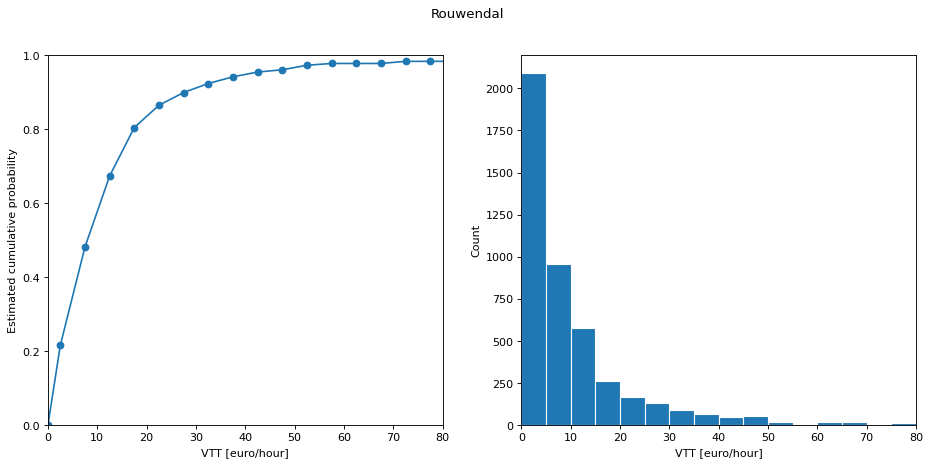

In [14]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1,2,figsize=(14,6), dpi=80)

# Plot CDF
ax[0].plot(vtt_mid,p,marker='o')
ax[0].set_xlim(0,80)
ax[0].set_ylim(0,1)
ax[0].set_xlabel('VTT [euro/hour]')
ax[0].set_ylabel('Estimated cumulative probability')

# Plot histogram
ax[1].set_xlim(0,80)
ax[1].set_xlabel('VTT [euro/hour]')
ax[1].set_ylabel('Count')
ax[1].hist(vtt, bins = vtt_grid,edgecolor="white")
fig.suptitle('Rouwendal')
plt.savefig('outcomes/rouwendal.png')
plt.show()